# Project: Quantification of Geometric Brownian Motion (GBM) Prediction of Equity Price Data

## Background
[Geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) is a continuous-time stochastic process model in which the random variable $S(t)$, e.g., the share price of `XYZ` is described by a deterministic drift corrupted by a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process):

$$\frac{dS}{S} = {\mu}dt + \sigma{dW}$$

The constant $\mu$ denotes a drift parameter, $\sigma$ indicates a volatility parameter, and $dW$ represents the output of a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process).  Using [Ito's lemma](https://en.wikipedia.org/wiki/Itô%27s_lemma), we can formulate an analytical solution to the GBM equation:

$$S(t) = S_{\circ}\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})Z(0,1)\Biggr]$$

where $S_{\circ}$ denotes the sharte price at $t_{\circ}$, and $Z(0,1)$ denotes a [standard normal random variable](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution). 

## Learning Objectives
In this project, students will test the _in sample_ effectiveness of the Geometric Brownian Motion (GBM) as a predictive approach for the forward projection of equity share price. 

* __Objective__: Quantify GBM model prediction rate by comparing historical data for different periods and firms with model predictions. Compute the probability of a `successful` prediction for each firm. 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3`


## Prerequisite: Load and Clean the Historical Price Dataset

We load the Open High Low Close (OHLC) data files for all firms for `Year-1 ... Year-5` using the `loaddatafile(...)` function. This function returns a `DataFrame` holding a year’s worth of data (approximately 252 records). Since we are loading multiple years of data for each firm, we combine all the annual `DataFrame` instances into a single `DataFrame` using the [DataFrame append! function](https://docs.juliahub.com/DataFrames/AR9oZ/0.21.5/lib/functions/#Base.append!). We store the combined `DataFrames` in the `dataset` dictionary where keys corresponding to the `firm_id`:

In [2]:
dataset = Dict{Int64,DataFrame}();
set_of_firms = generate_firm_index_set();

years = ["Year-1", "Year-2", "Year-3", "Year-4", "Year-5"];
while (isempty(set_of_firms) == false)
    firm_index = pop!(set_of_firms)
    
    for year ∈ years
        tmp_data = loaddatafile(firm=firm_index, year=year);
        
        if (haskey(dataset,firm_index) == false)
            dataset[firm_index] = tmp_data;
        else
            append!(dataset[firm_index], tmp_data)
        end
    end
end

Not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or were delisted, etc. We will exclude these firms from the `dataset`.

#### Implementation
First, we specify the `max_number_of_records` variable, which holds the number of trading records we expect for each firm, in this case, `1256`. Then, we iterate through the firms in the `dataset` using a `for` loop. We remove those firms from the `dataset` whose row count (calculated by calling the `nrow(...)` function) is not equal to the `max_number_of_records`; a firm is removed from the `dataset` using the [delete! function](https://docs.julialang.org/en/v1/base/collections/#Base.delete!):

In [3]:
max_number_of_records = 1256
number_of_firms = length(dataset)
for (firm_index, data) ∈ dataset
    data = dataset[firm_index];
    
    if (nrow(data) != max_number_of_records)
        delete!(dataset, firm_index);
    end
end

list_of_firm_ids = keys(dataset) |> collect |> sort;
number_of_firms = length(list_of_firm_ids);

Finally, we've computed the geometric brownian motion model parameters $(\mu,\sigma)$ for each firm in the dataset and stored these values in a text file. We load the model parameters using the `loadmodelparametersfile()` function which returns a `DataFrame` of parameters, which we store in the `parameters` variable:

In [4]:
parameters = loadmodelparametersfile();

In [5]:
test_firm_index = 323;
firm_data = dataset[test_firm_index];
μ̂ = parameters[parameters.firm .== test_firm_index, :μ] |> first;
σ̂ = parameters[parameters.firm .== test_firm_index, :σ] |> first;
    
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

start_index = 630
stop_index = 756
Δt = (1.0/252.0)

Sₒ = firm_data[start_index,:volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt

X = solve(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

expectation = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

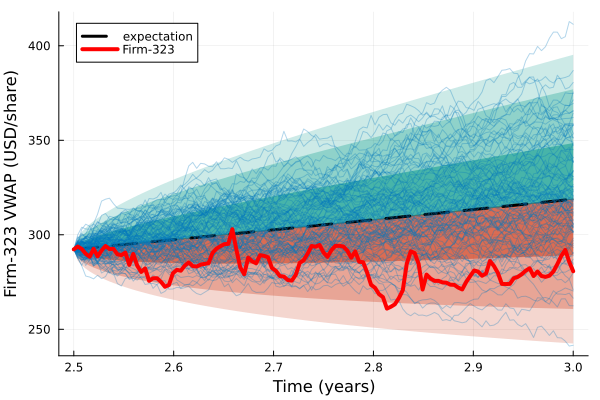

In [6]:
L68 = expectation[:,2] .- sqrt.(variance[:,2])
U68 = expectation[:,2] .+ sqrt.(variance[:,2])
L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])


plot(expectation[:,1], expectation[:,2], fillrange=L68, c=colors[5], alpha=0.5, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=colors[6], alpha=0.5, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=colors[5], alpha=0.3, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=colors[6], alpha=0.3, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=colors[5], alpha=0.2, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=colors[6], alpha=0.2, label="")

plot!(expectation[:,1], expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
plot!(X[:,1],X[:,2:end], label="", c=colors[2], alpha=0.3)
plot!(X[:,1], firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
    label="Firm-$(test_firm_index)")

xlabel!("Time (years)", fontsize=18)
ylabel!("Firm-$(test_firm_index) VWAP (USD/share)", fontsize=18)

## Objective: Quantify the _in sample_ Geometric Motion Model (GBM) Prediction Rate
This task aims to determine the prediction accuracy of the Binomial Lattice Model. To accomplish this, we will divide time into contiguous segments $\mathcal{I}_{k}\in\mathcal{I}$ of length `T` days. At the start of each interval $\mathcal{I}_{k}$, we will construct and populate a binomial lattice model using the `build(…)` and `populate(…)` functions. Then, we will compare the actual price of a firm denoted by $S_{j}$ at time $j$ with the simulated price during each time segment: 

* If the simulated price falls between a lower bound $L_{j}$ and an upper bound $U_{j}$ for all $j\in\mathcal{I}_{k}$, the simulation is considered a `success`. The lower $L_{j}$ and upper $U_{j}$ bounds can be specified. However, by default, they are set to $\mu\pm{2.576}\sigma$, where $\mu$ is the expected value and $\sigma$ is the standard deviation of the binomial lattice simulation.
* However, if the actual price violates either the lower or upper bound at any point, the simulation is deemed a `failure`.

First, specify the length of each time interval (in days) in the `T` variable:

In [7]:
T = 24;

Next, partition time into random intervals $\mathcal{I}_{k}\in\mathcal{I}$. We then define `date_range_set`, which holds time intervals $\mathcal{I}_{k}$, and populate $\mathcal{I}$ set using a `while` loop. For each pass of the loop, we randomly generate a `start_index`, and then compute a `stop_index` by adding the number of trading days `T` to the `start_index`. We continue iterating until we have generated `number_of_date_ranges` in $\mathcal{I}$:

In [8]:
date_range_set = Set{StepRange{Int64, Int64}}();
number_of_date_ranges = 100;
counter = 0
while (counter < number_of_date_ranges)
    
    start_index = rand(1:(max_number_of_records - T - 1))
    stop_index = start_index + T
    range(start_index, stop=stop_index, step=1) |> (x-> push!(date_range_set, x))
    
    counter = length(date_range_set);
end

### Simulation
The simulation code block is hidden and evaluates every firm in the `dataset` for each time interval in the `date_range_array`. It produces two data structures: 

1. The `success_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()` data structure contains simulation results for each time interval that has passed the bounds test mentioned earlier. The keys of this data structure correspond to the `firm_id`, while the values are an array of `DataFrames` that hold the simulation results for each period.

2. The `failed_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()` data structure contains simulation results that have failed the bounds test mentioned earlier. The keys of this data structure correspond to the `firm_id`, while the value is an array of `DataFrames` that encode the failed simulation results.The simulation code block is hidden and evaluates every firm in the `dataset` for each time interval in the `date_range_array`. It produces two data structures: 

In [9]:
success_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()
failed_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()
for firm_id ∈ list_of_firm_ids
    
    firm_data = dataset[firm_id];
    μ̂ = parameters[parameters.firm .== firm_id, :μ] |> first;
    σ̂ = parameters[parameters.firm .== firm_id, :σ] |> first;
    
    model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));
    
    date_range_set_copy = deepcopy(date_range_set)
    while (isempty(date_range_set_copy) == false)
        
        date_range = pop!(date_range_set_copy);
        start_index = first(date_range)
        stop_index = last(date_range)
        
        Sₒ = firm_data[start_index, :volume_weighted_average_price];
        T₁ = start_index*Δt
        T₂ = stop_index*Δt
        
        expectation = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
        variance = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
        
        L = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
        U = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])
   
        success_flag = true;
        for k ∈ 1:T
            if (firm_data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (firm_data[start_index+k-1,:volume_weighted_average_price] > U[k])
                success_flag = false;
                break;
            end
        end
        
        position_tuple = (firm_id, date_range)
        if (success_flag == true)
            push!(success_simulation_set, position_tuple);
        else
            push!(failed_simulation_set, position_tuple);
        end
    end 
end

#### Visualize a random `success` simulation:

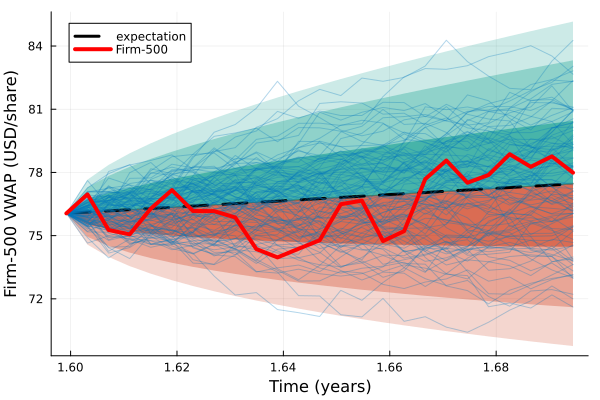

In [10]:
result_tuple = rand(success_simulation_set)
firm_id = result_tuple |> first;
firm_data = dataset[firm_id];

date_range = result_tuple |> last;
start_index = first(date_range)
stop_index = last(date_range)

Sₒ = firm_data[start_index, :volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt
        
expectation_success = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance_success  = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

X = solve(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

 # draw the plot -
L68 = expectation_success[:,2] .- sqrt.(variance_success[:,2])
U68 = expectation_success[:,2] .+ sqrt.(variance_success[:,2])
L95 = expectation_success[:,2] .- 1.96*sqrt.(variance_success[:,2])
U95 = expectation_success[:,2] .+ 1.96*sqrt.(variance_success[:,2])
L99 = expectation_success[:,2] .- 2.576*sqrt.(variance_success[:,2])
U99 = expectation_success[:,2] .+ 2.576*sqrt.(variance_success[:,2])

plot(expectation_success[:,1], expectation_success[:,2], fillrange=L68, c=colors[5], alpha=0.5, label="")
plot!(expectation_success[:,1], expectation_success[:,2], fillrange=U68, c=colors[6], alpha=0.5, label="")
plot!(expectation_success[:,1], expectation_success[:,2], fillrange=L95, c=colors[5], alpha=0.3, label="")
plot!(expectation_success[:,1], expectation_success[:,2], fillrange=U95, c=colors[6], alpha=0.3, label="")
plot!(expectation_success[:,1], expectation_success[:,2], fillrange=L99, c=colors[5], alpha=0.2, label="")
plot!(expectation_success[:,1], expectation_success[:,2], fillrange=U99, c=colors[6], alpha=0.2, label="")

plot!(expectation_success[:,1], expectation_success[:,2],c=:black, lw=3,ls=:dash, label="expectation")
plot!(X[:,1],X[:,2:end], label="", c=colors[2], alpha=0.3)
plot!(X[:,1], firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
    label="Firm-$(firm_id)")

xlabel!("Time (years)", fontsize=18)
ylabel!("Firm-$(firm_id) VWAP (USD/share)", fontsize=18)

#### Visualize a random `failed` simulation:

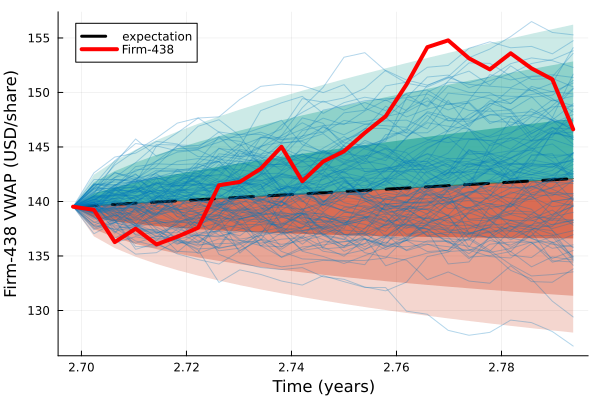

In [11]:
result_tuple = rand(failed_simulation_set)
firm_id = result_tuple |> first;
firm_data = dataset[firm_id];

date_range = result_tuple |> last;
start_index = first(date_range)
stop_index = last(date_range)

Sₒ = firm_data[start_index, :volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt
        
expectation_failed = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance_failed  = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

X = solve(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

 # draw the plot -
L68 = expectation_failed[:,2] .- sqrt.(variance_failed[:,2])
U68 = expectation_failed[:,2] .+ sqrt.(variance_failed[:,2])
L95 = expectation_failed[:,2] .- 1.96*sqrt.(variance_failed[:,2])
U95 = expectation_failed[:,2] .+ 1.96*sqrt.(variance_failed[:,2])
L99 = expectation_failed[:,2] .- 2.576*sqrt.(variance_failed[:,2])
U99 = expectation_failed[:,2] .+ 2.576*sqrt.(variance_failed[:,2])

plot(expectation_failed[:,1], expectation_failed[:,2], fillrange=L68, c=colors[5], alpha=0.5, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2], fillrange=U68, c=colors[6], alpha=0.5, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2], fillrange=L95, c=colors[5], alpha=0.3, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2], fillrange=U95, c=colors[6], alpha=0.3, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2], fillrange=L99, c=colors[5], alpha=0.2, label="")
plot!(expectation_failed[:,1], expectation_failed[:,2], fillrange=U99, c=colors[6], alpha=0.2, label="")

plot!(expectation_failed[:,1], expectation_failed[:,2],c=:black, lw=3,ls=:dash, label="expectation")
plot!(X[:,1],X[:,2:end], label="", c=colors[2], alpha=0.3)
plot!(X[:,1], firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
    label="Firm-$(firm_id)")

xlabel!("Time (years)", fontsize=18)
ylabel!("Firm-$(firm_id) VWAP (USD/share)", fontsize=18)

### Compute the probability of success $p_{+}$ for each firm
After analyzing the firms in both the `successful_simulation_dict` and `failed_simulation_dict`, it is evident that the lattice model has failed to predict share prices on at least one occasion for every firm in the `dataset`. To determine the likelihood of the lattice model succeeding, we examine the `successful_simulation_dict` data structure and estimate the probability that the lattice model can successfully predict equity prices: 

In [12]:
probability_dictionary = Dict{Int64, Float64}()
for success_case ∈ success_simulation_set
    
    firm_id = success_case |> first;
    if (haskey(probability_dictionary, firm_id) == false)
        probability_dictionary[firm_id] = (1/number_of_date_ranges);
    else
        probability_dictionary[firm_id] += (1.0/number_of_date_ranges);
    end
end

In [13]:
probability_dictionary

Dict{Int64, Float64} with 458 entries:
  56  => 0.43
  35  => 0.47
  425 => 0.38
  429 => 0.34
  308 => 0.57
  67  => 0.29
  215 => 0.64
  319 => 0.45
  251 => 0.4
  112 => 0.48
  348 => 0.49
  185 => 0.35
  420 => 0.45
  404 => 0.3
  417 => 0.58
  365 => 0.61
  333 => 0.42
  86  => 0.42
  168 => 0.37
  431 => 0.36
  263 => 0.55
  422 => 0.47
  207 => 0.28
  242 => 0.41
  183 => 0.49
  ⋮   => ⋮

In [15]:
probability_dictionary[215]

0.6400000000000003